# Exercise 4: Short-time Fourier Transform

Doing this exercise you will learn about the concept of the main lobe width of the spectrum of a window and you will better understand the short-time Fourier transform (STFT). You will also use the STFT to extract basic rhythm related information from an audio signal, implementing an onset detection function, which is one of the rhythm descriptors often used in music information retrieval to detect onsets of acoustic events. 

There are four parts in this exercise. 1) Extracting the main lobe of the spectrum of a window, 2) Measuring noise in the reconstructed signal using the STFT model, 3) Computing band-wise energy envelopes of a signal, 4) Computing an onset detection function.


### Relevant Concepts

__Main lobe of the spectrum of a window:__
The width of the main lobe of the magnitude spectrum of a window is an important characteristic used in deciding which window type is best for the analysis of an audio excerpt. There exists a tradeoff between the main lobe width and the side lobe attenuation. Typically for windows with a narrower main lobe, the side lobes are less attenuated. 
An interesting fact is that changing the length of a window $M$ doesn't affect the main lobe width of the spectrum of the window in samples. Note that if you use zero-padding for computing the spectrum of a window, the main lobe width will be multiplied by the zero-padding factor.

__Fast Fourier Transform (FFT):__
An efficient way to compute the discrete Fourier transform of a signal is the fast Fourier transform, FFT. The FFT algorithm  factorizes the DFT matrix in order to exploit the symmetries in the DFT equation. FFT computation is specially very efficient when the FFT size is a power of 2. Therefore, whenever possible we use an FFT size that is a power of 2.

__Energy of a signal:__ The energy of a signal $x[n]$ of length $N$ can be computed in the discrete time domain as follows:
\begin{equation}
E=\overset{N-1}{\underset{n=0}{\sum}}\left|x\left[n\right]\right|^{2}
\end{equation}

__Energy in a frequency band:__ Given the DFT spectrum of the signal $X[k]$, the energy $E$ in a specific frequency band spanning the bin index $k_1$ to $k_2$ can be computed as:

\begin{equation}
E=\overset{k_{2}}{\underset{k=k_{1}}{\sum}}\left|X\left[k\right]\right|^{2}
\end{equation}

Note that in this computation the $X[k]$ values are not in decibels (dB). The `stftAnal()` function returns magnitude spectra in dB scale, which should be converted to linear scale before the energy computation. Once the energy is computed it can be converted back to the dB scale as:

\begin{equation}
E_{dB}= 10\,\log_{10}(E)
\end{equation}

__Signal to noise ratio (SNR):__
Signal to noise ratio (SNR) is a frequently used measure to quantify the amount of noise present/added in a signal. In the context of this exercise it can be computed in decibels (dB) as:

\begin{equation}
\mathrm{SNR} = 10\,\log_{10}\left(\frac{E_{\mathrm{signal}}}{E_{\mathrm{noise}}}\right)
\end{equation}

where, $E_{\mathrm{signal}}$ and $E_{\mathrm{noise}}$ are the energy of the signal and noise respectively.

For our case of analysis and synthesis using a specific model (for example, STFT) noise can be thought of as the difference between the input signal and the output signal of the model.

__Onset detection function:__
An onset detection function (ODF) refers to a continuous function (one value per audio frame) often used for detecting acoustic events in an audio stream. In music information retrieval (MIR), ODFs are typically used for detecting onsets of musical notes and percussion strokes. An ODF generally has high values at the onsets of acoustic events. A simple ODF can be computed by taking the difference between the energy values of consecutive frames, as shown below:

\begin{equation}
O(l) = E(l) - E(l-1) ,\,\,\,\,\, l \geq 1
\end{equation}

where, $O(l)$ is the ODF computed at frame index $l$ and $E$ is the energy of the signal in a particular frequency band in decibels (dB). Often, multiple ODFs are computed with different frequency bands across the spectrum. 

In order to detect only the onsets of the events and not the offsets, it is a common practice to half wave rectify the ODF and obtain $\bar{O}(l)$. Half wave rectification of the ODF is given by:

 \begin{equation}
 \bar{O}(l)=\begin{cases}
 \begin{array}{c}
 O(l), \, \mathrm{if} \,\,O(l)>0\\
 \,\,\,\,0, \,\,\,\,\, \mathrm{if} \,\, O(l)\leq0
 \end{array}\end{cases} 
 \end{equation}

## Part 1 - Extracting the main lobe of the spectrum of a window

The function `extract_main_lobe()` should extract the main lobe of the magnitude spectrum of a window given a window type, `window`, and its length, `M`. The function should return the samples corresponding to the main lobe in decibels (dB).

To compute the spectrum you should take the FFT size (`N`) to be 8 times the window length (`N = 8*M`) (For this part, `N` does not need to be a power of 2). 

The input arguments to the function are the window type (`window`) and the length of the window (`M`). The function should return a numpy array containing the samples corresponding to the main lobe of the window. In the returned numpy array you should include the samples corresponding to both the local minimas across the main lobe. 

The possible window types that you can expect as input are rectangular (`'boxcar'`), `'hamming'` or `'blackmanharris'`.

NOTE: You can approach this task by writing code to find the indices of the local minimas across the main lobe.

_Tip:_ `log10(0)` is not well defined, so its a common practice to add a small value such as `eps = 1e-16` to the magnitude spectrum before computing it in dB. This is optional and will not affect your answers. 
If you find it difficult to concatenate the two halves of the main lobe, you can first center the spectrum using `fftshift()` and then compute the indexes of the minimas around the main lobe.

In [1]:
import os
import sys
import numpy as np

from scipy.signal import get_window
from scipy.fftpack import fft, fftshift

import math
import matplotlib.pyplot as plt
# %matplotlib notebook
eps = np.finfo(float).eps

sys.path.append('../software/models/')
import stft
import utilFunctions as UF

In [111]:
# E4 - 1.1: Complete function extract_main_lob()

def extract_main_lobe(window, M, N):
    """Extract the main lobe of the magnitude spectrum of a window, given a window type and its length.
    
    Args:
        window (str): Window type to be used (either rectangular ('boxcar'), 'hamming' or 'blackmanharris')
        M (int): length of the window to be used
        N (int): size of FFT
        
    Results:
        np.array: an array containing the main lobe of the magnitude spectrum of the window in decibels (dB).
    """

    w = get_window(window, M)         # get the window 
    
    ### Your code here
    X = fft(w, N)

    X = fftshift(X)

    X = X + eps
    X = np.log10(X)

    peak = np.argmax(X)
    half_width = 0
    for i in range(len(X[peak:])):
        if X[peak+i] < X[peak+i+1]:
            half_width = i
            break
        
    main_lobe = X[peak-half_width:peak+half_width+1] # add 1 because the slices are not inclusive

    return main_lobe

Test cases for the function `extract_main_lobe()`:

_Test case 1:_ If you run your code using `window = 'blackmanharris'`, `M = 100` and `N = 800`, the output numpy array should contain 65 samples.

_Test case 2:_ If you run your code using `window = 'boxcar'`, `M = 120` and `N = 960`, the output numpy array should contain 17 samples.

_Test case 3:_ If you run your code using `window = 'hamming`, `M = 256`, and `N = 2048`, the output numpy array should contain 33 samples.

To understand better the result you can plot the magnitude spectrum of the window and mark the boundaries of the main lobe.

Main Lobe Width: 65
Normalized Main Lobe Width: 8.125


/Users/mhabana/dev/learning/upf/t1/audio_signal_processing/venv/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/mhabana/dev/learning/upf/t1/audio_signal_processing/venv/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


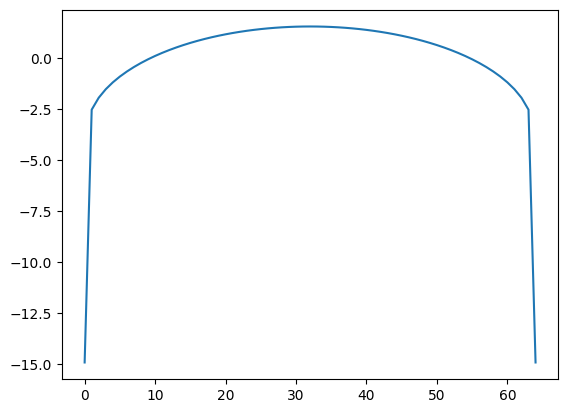

In [112]:
# E4 - 1.2: Call extract_main_lobe() with the 3 test cases mentioned and plot the magnitude spectra of the windows with 
# the location of the main-lobe boundaries. Compute and explain the normalized main-lobe width (dividing by the 
# zero-padding factor), comparing it with the values presented in the theory.

### Your code here

# Test Case 1:

window = 'blackmanharris'
M = 100
N = 800

X = extract_main_lobe(window, M, N)
print("Main Lobe Width: " + str(len(X)))
print("Normalized Main Lobe Width: " + str(len(X) / (N/M)))
plt.plot(X)

Main Lobe Width: 17
Normalized Main Lobe Width: 2.125


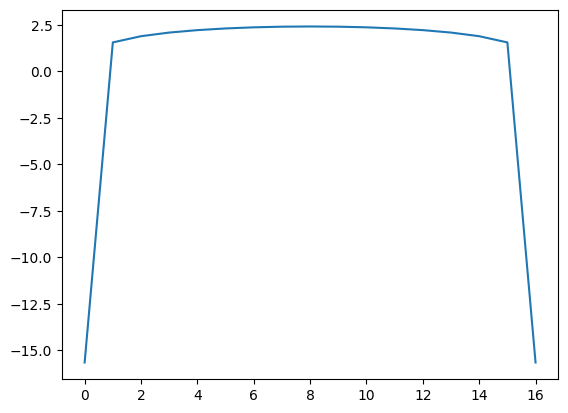

In [113]:
# Test Case 2

window = 'boxcar'
M = 256
N = 2048

X = extract_main_lobe(window, M, N)
print("Main Lobe Width: " + str(len(X)))
print("Normalized Main Lobe Width: " + str(len(X) / (N/M)))
plt.plot(X)

Main Lobe Width: 33
Normalized Main Lobe Width: 4.125


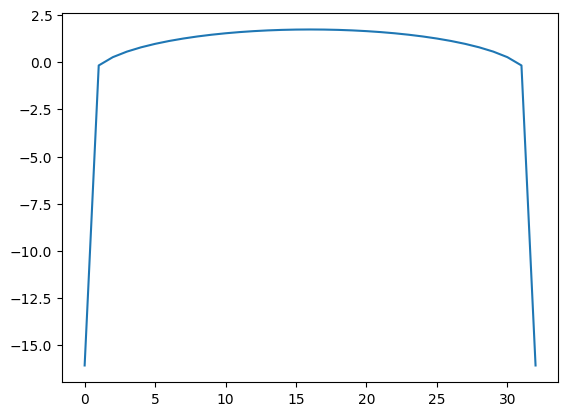

In [114]:
# Test Case 3:

window = 'hamming'
M = 100
N = 800

X = extract_main_lobe(window, M, N)
print("Main Lobe Width: " + str(len(X)))
print("Normalized Main Lobe Width: " + str(len(X) / (N/M)))
plt.plot(X)

In [115]:
window = 'hamming'
M = 100
N = 4096

X = extract_main_lobe(window, M, N)
print("Main Lobe Width: " + str(len(X)))
print("Normalized Main Lobe Width: " + str(len(X) / (N/M)))

Main Lobe Width: 165
Normalized Main Lobe Width: 4.0283203125


In [116]:
window = 'hamming'
M = 50
N = 4096

X = extract_main_lobe(window, M, N)
print("Main Lobe Width: " + str(len(X)))
print("Normalized Main Lobe Width: " + str(len(X) / (N/M)))

Main Lobe Width: 329
Normalized Main Lobe Width: 4.01611328125


### Why does the normalized main lobe width not equal the theoretical lobe width

As we see in the analysis above the main lobe width the normalized main lobe width is not exactly equal to the theoretical main lobe width of the function. We can see that it is off by about 0.125. Playing around with the values we can see that if we increase the FFT size and/or decrease the window size the normalized main lobe width begins to approach the theoretical main lobe width. I believe that we are never able to truly get the theoretical main lobe width because we would need an infinite length DFT to be able to accurately sample the the lobe width. Because of the lack of samples the output of the DFT is not able to accurately find the exact point where the local minimum of the main lobe lies and the points that we are finding are just approximate locations of the local minimums.

## Part 2 - Measuring noise in the reconstructed signal using the STFT model 

The function `compute_snr()` should measure the amount of distortion introduced during the analysis and synthesis of a signal using the STFT model. Use SNR (signal to noise ratio) in dB to quantify the amount of noise. 
Use the `stft()` function in `stft.py` to do an analysis followed by a synthesis of the input signal.

Use the time domain energy definition to compute the SNR. With the input signal and the obtained output, compute two different SNR values for the following cases:

1. `SNR1`: Over the entire length of the input and the output signals.
2. `SNR2`: For the segment of the signals left after discarding `M` samples from both the start and the end, where `M` is the analysis window length. 

Note that the computations are done after STFT analysis and synthesis. The input arguments to the function are the wav file name including the path (`input_file`), window  type (`window`), window length (`M`), FFT size (`N`), and hop size (`H`). The function should return a python tuple of both the SNR values in decibels. Both SNR1 and SNR2 are float values. 

In [199]:
# E4 - 2.1: Complete function compute_snr()

def compute_snr(input_file, window, M, N, H):
    """Measure the amount of distortion introduced during the analysis and synthesis of a signal using the STFT model.
    
    Args:
        input_file (str): wav file name including the path 
        window (str): analysis window type (rectangular, triangular, hanning, hamming, blackman, or blackmanharris)
        M (int): analysis window length (odd positive integer)
        N (int): fft size (power of two, > M)
        H (int): hop size for the stft computation
            
    Result:
        tuple with the signal to noise ratio over the whole sound and of the sound without the begining and end.
    """
    ### your code here

    fs, x = UF.wavread(input_file)

    w = get_window(window, M)

    mX, pX = stft.stftAnal(x, w, N, H)

    x_synth = stft.stftSynth(mX, pX, M, H)[:len(x)] # the length of the synthesized sound sometimes mismatches the length of the original sound

    E_x = np.sum(np.square(np.abs(x)))
    E_noise = np.sum(np.square(np.abs(np.subtract(x,x_synth))))

    E_x_normalized = np.sum(np.square(np.abs(x[M:-M])))
    E_noise_normalized =  np.sum(np.square(np.abs(np.subtract(x[M:-M],x_synth[M:-M]))))

    SNR1 = 10 * np.log10(E_x / E_noise)
    SNR2 = 10 * np.log10(E_x_normalized / E_noise_normalized)

    return (SNR1, SNR2)


Test cases for the function `compute_snr()`:

_Test case 1:_ If you run your code using `piano.wav` file with `'blackman'` window, `M = 513`, `N = 2048` and 
`H = 128`, the output SNR values should be around: `(67.57748352378475, 86.35716169253175)`.

_Test case 2:_ If you run your code using `sax-phrase-short.wav` file with `'hamming'` window, `M = 512`, 
`N = 1024` and `H = 64`, the output SNR values should be around: `(89.510506656299285, 306.18696700251388)`.

_Test case 3:_ If you run your code using `rain.wav` file with `'hann'` window, `M = 1024`, `N = 2048` and 
`H = 128`, the output SNR values should be around: `(74.631476225366825, 304.26918192997738)`.

Due to precision differences on different machines/hardware, compared to the expected SNR values, your output values can differ substantially.

In [200]:
# E4 - 2.2: Call the function compute_snr() for the 3 test cases mentioned, explain the results

### Your code here

# Test Case 1:

input_file = '../sounds/piano.wav'
window = 'blackman'
M = 513
N = 2048
H = 128

print(compute_snr(input_file, window, M, N, H))

(67.54018457559313, 86.35716036008236)


In [209]:
# Test Case 1.1:

input_file = '../sounds/piano.wav'
window = 'blackman'
M = 513
N = 2048
H = 64

print(compute_snr(input_file, window, M, N, H))

(68.18070421714653, 95.02406491455983)


In [211]:
# Test Case 1.2:

input_file = '../sounds/piano.wav'
window = 'blackman'
M = 513
N = 2048
H = 2

print(compute_snr(input_file, window, M, N, H))

(67.19642217680399, 305.6619383805917)


In [220]:
# Test Case 1.2:

input_file = '../sounds/piano.wav'
window = 'blackman'
M = 513
N = 2048
H = 128

print(compute_snr(input_file, window, M, N, H))

(67.54018457559313, 86.35716036008236)


In [191]:
# Test Case 2:

input_file = '../sounds/sax-phrase-short.wav'
window = 'hamming'
M = 512
N = 1024
H = 64

print(compute_snr(input_file, window, M, N, H))

1.3636801190589134e-06
2.763022973715933e-28
(89.51050629592375, 306.4437864264664)


In [206]:
# Test Case 3:

input_file = '../sounds/rain.wav'
window = 'hann'
M = 1024
N = 2048
H = 128

print(compute_snr(input_file, window, M, N, H))

(74.63147527768996, 305.5293706515355)


### Analysis

The first insight is the difference between SNR1 and SNR2. We notice a much higher SNR because we remove the start and end of the signal because of the windowing. When we window we aren't able to take an accurate representation of the start and end of the sound, because the window is only able to accurately capture the center point of the window and then as we perform the DFT it averages out to capture more accurately the middle portions of the sound. Since the first M samples are not evenly windowed to get an accurate average there is a lot of noise or distortion in the first M samples.

Another difference between the three test cases is that the second and third test case have even window lengths. This causes the windowed analysis to become a symmetric function which will cause some aliasing because there is no definative peak on the windowed functions magnitude spectrum. Although I'm not sure why when the window size is a power of 2 the SNR2 score is so much better than when it is a normal even number.

Playing around with input of the first test case we can see that if we reduce the hop size it will improve the overall SNR. Intuitively this makes sense since we are now slowly windowing over the entire signal, which will result in a better average that more accurately captures the information from the original signal. As seen in test case 1.1 & 1.2. Although if we make our hop size too small it will increase the impact of amplitude modulation on the magnitude spectrum and in turn the synthesized sound as seen in the case of 1.2. It greatly improved the SNR in the middle of the sound as seen in SNR2 but maybe because of the amplitude modulation it negatively impacted the the SNR1 score.

## Part 3 - Computing band-wise energy envelopes of a signal

The function `compute_eng_env()` should compute band-wise energy envelopes of a given audio signal using the STFT.

Consider two frequency bands, low and high. The low frequency band is the set of frequencies between 0 and 3000 Hz and the high frequency band is the set of frequencies between 3000 and 10000 Hz (excluding the boundary frequencies in both the cases). At a given frame, the value of the energy envelope of a band can be computed as the sum of squared values of all the frequency coefficients in that band. Then you should compute the energy envelopes in decibels. 

The input arguments are the wav file name including the path (`input_file`), window type (`window`), window length (`M`), FFT size (`N`) and hop size (`H`). The function should return a numpy array with two columns, where the first column is the energy envelope of the low frequency band and the second column is that of the high frequency band.

Use `stftAnal()` function from `stft.py` module to obtain the magnitude spectra for all the audio frames of the input sound. Then compute the energy values for each frequency band specified. While calculating frequency bins for each frequency band, consider only the bins that are within the specified frequency range. For example, for the low frequency band consider only the bins with frequency > 0 Hz and < 3000 Hz (you can use `np.where()` to find those bin indexes). This way you also remove the DC offset of the signal in energy envelope computation. The frequency corresponding to the bin index `k` can be computed as `k*fs/N`, where `fs` is the sampling rate of the signal.

In [317]:
# E4 - 3.1: Complete function compute_eng_env()

def compute_eng_env(input_file, window, M, N, H):
    """Compute band-wise energy envelopes of a given audio signal using the STFT.
    
    Args:
        input_file (string): input sound file (monophonic with sampling rate of 44100)
        window (string): analysis window type (choice of rectangular, triangular, hanning, 
                hamming, blackman, blackmanharris)
        M (integer): analysis window size (odd positive integer)
        N (integer): FFT size (power of 2, such that N > M)
        H (integer): hop size for the stft computation
        
    Result:
        np.array: magnitude spectra of sound (2D array)
        np.array: 2D numpy array with energy envelope of band 0 < f < 3000 Hz (in dB) in first column, [:,0]
        np.array: energy envelope of band 3000 < f < 10000 Hz (in dB) in second column [:,1]
    """
    
    ### your code here

    fs, x = UF.wavread(input_file)
    w = get_window(window, M)
    
    mX, pX = stft.stftAnal(x, w, N, H)

    border_bin = int(np.ceil(float(3000) * N / fs))
    max_bin = int(np.ceil(float(10000) * N / fs))

    low = np.transpose(np.transpose(mX)[1:border_bin])
    high = np.transpose(np.transpose(mX)[border_bin:max_bin])
    
    e_low = 10 * np.log10(np.sum((10 ** (low / 20)) ** 2, axis=1))
    e_high = 10 * np.log10(np.sum((10 ** (high / 20)) ** 2, axis=1))
    
    envelope = np.append([e_low], [e_high], axis=0)
    envelope = np.transpose(envelope)
    
    # plot the graphs
    # combined the plotting so that getting the details of the input signal won't be redundant
    plt.figure(1, figsize=(9.5, 6))

    plt.subplot(211)
    numFrames = mX.shape[0]
    frmTime = H*np.arange(numFrames)/float(fs)
    binFreq = np.arange(mX.shape[1])*float(fs)/N
    plt.pcolormesh(frmTime, binFreq, np.transpose(mX))
    plt.title('mX ({0}), M={1}, N={2}, H={3}'.format(input_file, M, N, H))
    plt.autoscale(tight=True)
    
    plt.subplot(212)
    plt.plot(frmTime, e_low, color="blue", label="low")
    plt.plot(frmTime, e_high, color="red", label="high")
    plt.title('Energy of Envelopes')
    plt.autoscale(tight=True)

    plt.tight_layout()
    plt.show()

    return envelope


Test cases for the function `compute_eng_env()`:

_Test case 1:_ Use `piano.wav` file with `window = 'blackman'`, `M = 513`, `N = 1024` and `H = 128` as input. 
The bin indexes of the low frequency band span from 1 to 69 (69 samples) and of the high frequency 
band span from 70 to 232 (163 samples).

_Test case 2:_ Use `piano.wav` file with `window = 'blackman'`, `M = 2047`, `N = 4096` and `H = 128` as input. 
The bin indexes of the low frequency band span from 1 to 278 (278 samples) and of the high frequency 
band span from 279 to 928 (650 samples).

_Test case 3:_ Use `sax-phrase-short.wav` file with `window = 'hamming'`, `M = 513`, `N = 2048` and `H = 256` as 
input. The bin indexes of the low frequency band span from 1 to 139 (139 samples) and of the high 
frequency band span from 140 to 464 (325 samples).

To get a better understanding of the band-wise energy envelope and its characteristics you can plot the envelopes together with the spectrogram of the signal. You can use `matplotlib` plotting library for this purpose. To visualize the spectrogram of a signal, a good option is to use the function `colormesh()` (you can reuse the code in
`lectures/4-STFT/plots-code/spectrogram.py`). Either overlay the envelopes on the spectrogram 
or plot them in a different subplot. Make sure you use the same range of the x-axis for both the spectrogram and the energy envelopes.

You can clearly notice the sharp attacks and decay of the piano notes for test case 1. You can compare this with the output from test case 2 that uses a larger window. You can infer the influence of window size on sharpness of the note attacks.

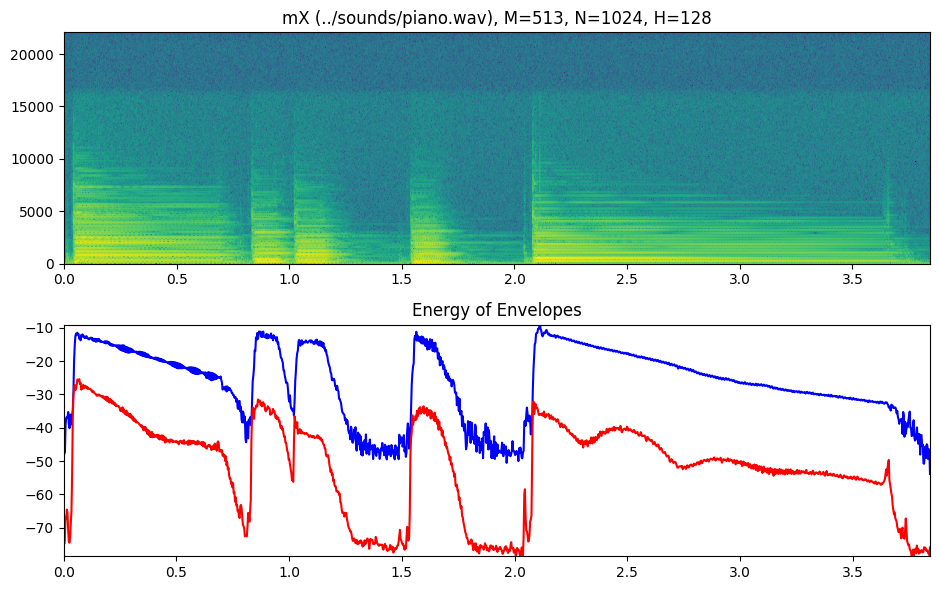

In [365]:
# E4 - 3.2: Call the function compute_eng_env() and plot the envelopes together with the 
# spectrogram of the signal

### Your code here

# Test Case 1:

input_file = '../sounds/piano.wav'

winodow = 'blackman'
M = 513
N = 1024
H = 128

env = compute_eng_env(input_file, window, M, N, H)


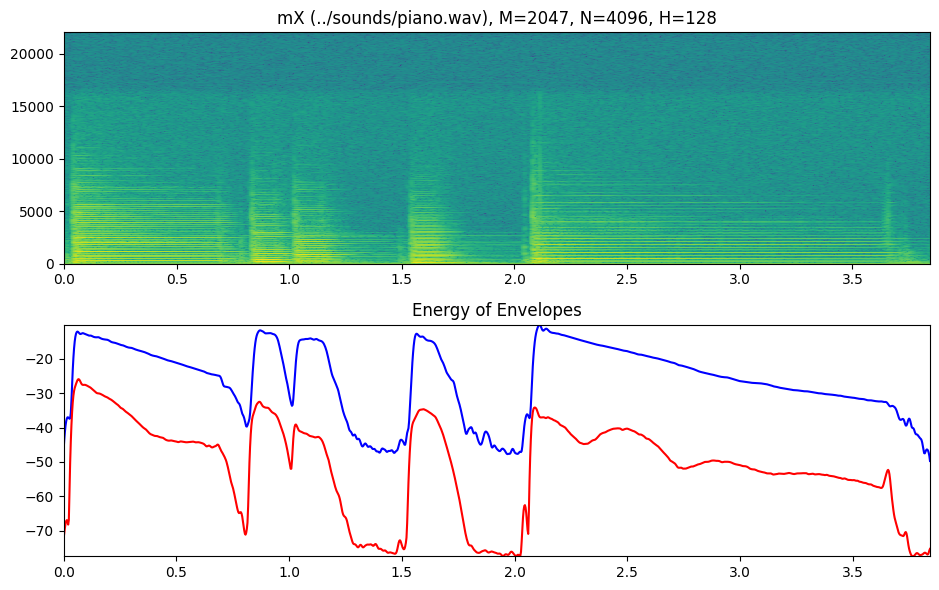

In [366]:
# Test Case 2:

input_file = '../sounds/piano.wav'

winodow = 'blackman'
M = 2047
N = 4096
H = 128

env = compute_eng_env(input_file, window, M, N, H)

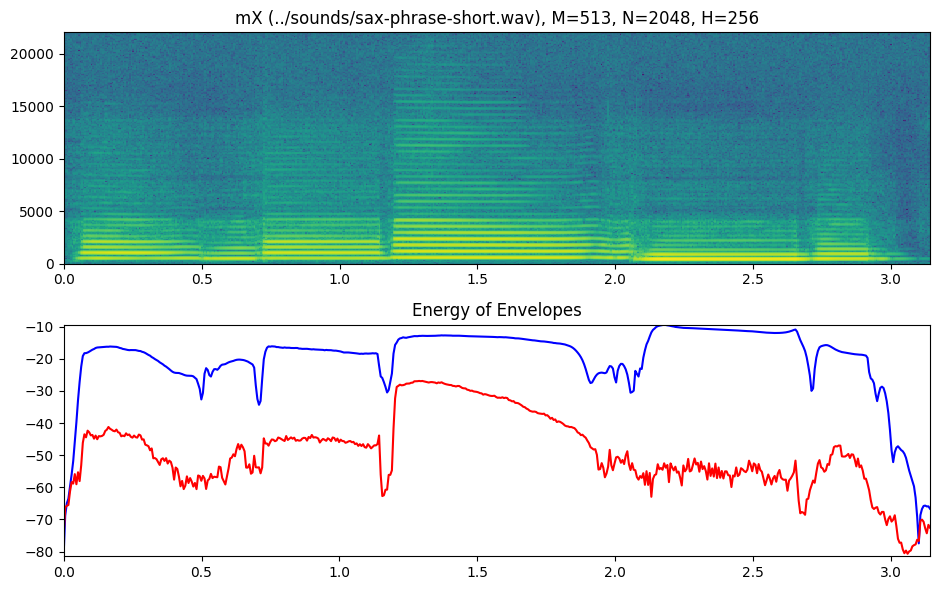

In [367]:
input_file = '../sounds/sax-phrase-short.wav'

winodow = 'hamming'
M = 513
N = 2048
H = 256

env = compute_eng_env(input_file, window, M, N, H)

## Part 4 - Computing onset detection function

The function `compute_odf()` should compute a simple onset detection function (ODF) using the STFT. It should compute two ODFs one for each of the frequency bands, low and high. The low frequency band is the set of all the frequencies between 0 and 3000 Hz and the high frequency band is the set of all the frequencies between 3000 and 10000 Hz (excluding the boundary frequencies in both the cases). 

Start with an initial condition of `ODF(0) = 0` in order to make the length of the ODF same as that of the energy envelope. Remember to apply a half wave rectification on the ODF. 

The input arguments to the function are the wav file name including the path (`input_file`), window 
type (`window`), window length (`M`), FFT size (`N`), and hop size (`H`). The function should return a numpy 
array with two columns, where the first column is the ODF computed on the low frequency band and the 
second column is the ODF computed on the high frequency band.

Use `stftAnal()` to obtain the magnitude spectra for all the audio frames. Then compute the band-wise energy envelope for each frequency band specified. Finally compute the half wave rectify version of ODF from each energy envelope.


In [ ]:
import IPython.display as ipd

In [377]:
# E4 4.1: Complete function compute_odf()

def compute_odf(input_file, window, M, N, H):
    """Compute a simple onset detection function (ODF) using the STFT.
    
    Args:
        input_file (str): input sound file (monophonic with sampling rate of 44100)
        window (str): analysis window type (rectangular, triangular, hanning, hamming, blackman, or blackmanharris)
        M (int): analysis window size (odd integer value)
        N (int): fft size (power of two, bigger or equal than than M)
        H (int): hop size for the STFT computation
        
    Result:
            np.array: magnitude spectra of sound (2D array)
            np.array: D numpy array with ODF computed in band 0 < f < 3000 Hz (in dB) in first column, [:,0]
            np.array: ODF computed of band 3000 < f < 10000 Hz (in dB) in second column [:,1]
    """
    
    ### your code here

    def odf(eg):
        o = eg - np.roll(eg, 1)
        o[0] = 0
        o[o <= 3] = 0
        return o

    fs, x = UF.wavread(input_file)
    w = get_window(window, M)
    
    mX, pX = stft.stftAnal(x, w, N, H)

    border_bin = int(np.ceil(float(3000) * N / fs))
    max_bin = int(np.ceil(float(10000) * N / fs))

    low = np.transpose(np.transpose(mX)[1:border_bin])
    high = np.transpose(np.transpose(mX)[border_bin:max_bin])
    
    e_low = 10 * np.log10(np.sum((10 ** (low / 20)) ** 2, axis=1))
    e_high = 10 * np.log10(np.sum((10 ** (high / 20)) ** 2, axis=1))

    odf_low = odf(e_low)
    odf_high = odf(e_high)
    
    odfs = np.append([odf_low], [odf_high], axis=0)
    odfs = np.transpose(odfs)

    # play the sound
    ipd.display(ipd.Audio(data=x, rate=fs))
    
    # plot the graphs
    # combined the plotting so that getting the details of the input signal won't be redundant
    plt.figure(1, figsize=(9.5, 6))

    plt.subplot(311)
    numFrames = mX.shape[0]
    frmTime = H*np.arange(numFrames)/float(fs)
    binFreq = np.arange(mX.shape[1])*float(fs)/N
    plt.pcolormesh(frmTime, binFreq, np.transpose(mX))
    plt.title('mX ({0}), M={1}, N={2}, H={3}'.format(input_file, M, N, H))
    plt.autoscale(tight=True)
    
    plt.subplot(312)
    plt.plot(frmTime, odf_low, color="blue", label="low")
    plt.plot(frmTime, odf_high, color="red", label="high")
    plt.title('Onset Detection')
    plt.autoscale(tight=True)

    plt.subplot(313)
    plt.plot(frmTime, e_low, color="blue", label="low")
    plt.plot(frmTime, e_high, color="red", label="high")
    plt.title('Energy of Envelopes')
    plt.autoscale(tight=True)

    plt.tight_layout()
    plt.show()

    return odfs
    

Test cases for the function `compute_odf()`:

_Test case 1:_ Use `piano.wav` file with `window = 'blackman'`, `M = 513`, `N = 1024` and `H = 128` as input. 
The bin indexes of the low frequency band span from 1 to 69 (69 samples) and of the high frequency 
band span from 70 to 232 (163 samples). 

_Test case 2:_ Use `piano.wav` file with `window = 'blackman'`, `M = 2047`, `N = 4096` and `H = 128` as input. 
The bin indexes of the low frequency band span from 1 to 278 (278 samples) and of the high frequency 
band span from 279 to 928 (650 samples). 

_Test case 3:_ Use `sax-phrase-short.wav` file with `window = 'hamming'`, `M = 513`, `N = 2048` and `H = 256` as 
input. The bin indexes of the low frequency band span from 1 to 139 (139 samples) and of the high 
frequency band span from 140 to 464 (325 samples).

To get a better understanding of the ODFs and their characteristics you can plot the ODF functions together with the spectrogram of the signal. Use the same plotting than in the previos part.

In order to identify the actual onsets of a signal you would need to find the peaks, local maxima, of the ODF functions using a magnitude threshold. Which of the 2 ODFs (low or high frequencies) would be most useful? What would be the right threshold for all 3 cases? Could you find a single threshold to be used for all 3 cases?

For test case 1, you should clearly see that the ODFs have sharp peaks at the onset of the piano notes. You should notice 5 peaks that are above 10dB value in the ODF computed on the high frequency band. 

In [383]:
f = np.arange(10)
print(f)
f_1 = np.roll(f, 1)
print(f_1)

[0 1 2 3 4 5 6 7 8 9]
[9 0 1 2 3 4 5 6 7 8]


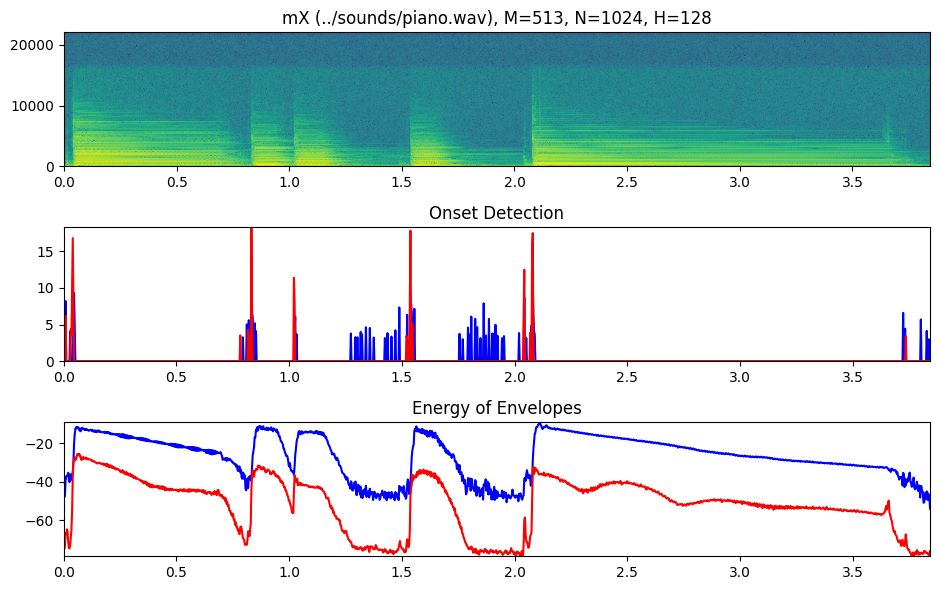

In [378]:
# E4 - 4.2: Call the function compute_odf() for the 3 test cases and plot the ODF functions together with the 
# spectrogram of the signal.

### Your code here

# Test Case 1

input_file = '../sounds/piano.wav'

winodow = 'blackman'
M = 513
N = 1024
H = 128

env = compute_odf(input_file, window, M, N, H)

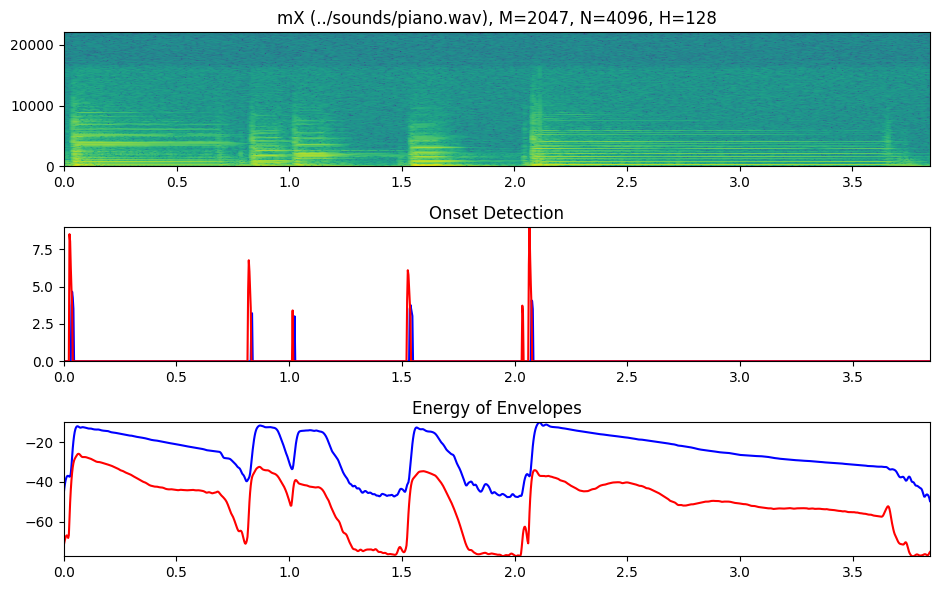

In [379]:
# Test Case 2
input_file = '../sounds/piano.wav'

winodow = 'blackman'
M = 2047
N = 4096
H = 128

env = compute_odf(input_file, window, M, N, H)

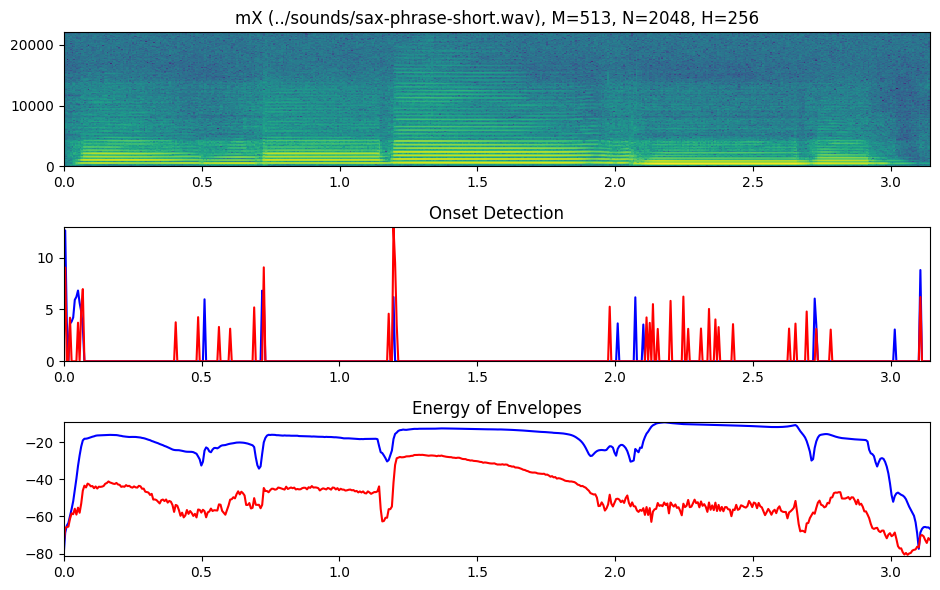

In [380]:
# Test Case 3

input_file = '../sounds/sax-phrase-short.wav'

winodow = 'hamming'
M = 513
N = 2048
H = 256

env = compute_odf(input_file, window, M, N, H)

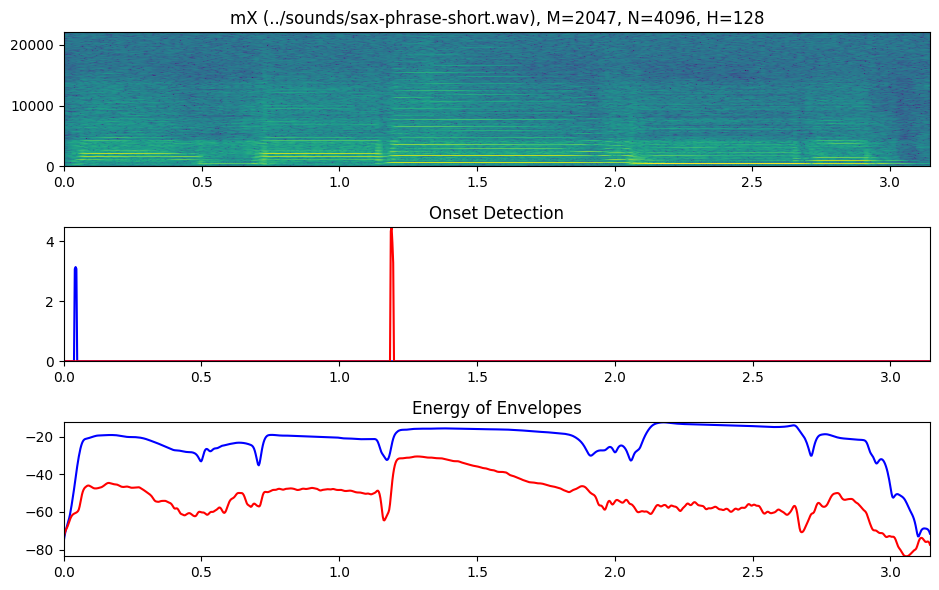

In [382]:
input_file = '../sounds/sax-phrase-short.wav'

winodow = 'blackman'
M = 2047
N = 4096
H = 128
env = compute_odf(input_file, window, M, N, H)

In [ ]:
# E4 - 4.3: Explain the results of Part 4
'''
For my ODF function I used a rather simple heuristic, of finding the change in dB between the current bin and 
its previous bin,then I applied a threshold change of 3 dB which would theoretically represent a doubling of 
sound pressure which I believe would represent a significant change in the sound. I think this threshold would 
well for both cases especially in the case of the saxaphone where a significant air sound pressure change would
mean more effort is exerted when blowing through the instrument. In the case of the piano not so but it at least
gets rid of some of the tiny changes in sound.

In comparing the two ODFs for the piano we can see that the parameters of the second case results in a better ODF.
This is because the graph of the energy envelopes results in a much smoother graph because of the larger window size
so it is better at finding the change in dB compared to the first test case. The larger window size results in a smoother
graph because it is taking the averages over a larger sample of sound so that as we reconstruct the sound after the window
it gets a much smoother average.

The ODF performs poorer on the saxaphone example because the sound is more stable, and doesnt have a sharp attack or dB change
which makes it much more difficult to find the exact point that the notes are changing.

'''
